https://keras.io/examples/timeseries/timeseries_anomaly_detection/

Anomaly detection in time series data refers to the task of identifying unusual or unexpected events in a sequence of data points collected over time. One approach to detecting anomalies in time series data is to use an autoencoder, which is a type of neural network that is trained to reconstruct a given input.

An autoencoder consists of two parts: an encoder and a decoder. The encoder maps the input data to a lower-dimensional representation, called the latent representation, while the decoder maps the latent representation back to the original input space. The goal of training an autoencoder is to learn a function that can reconstruct the input data accurately, such that the difference between the input and the reconstructed output is minimized.

To detect anomalies in time series data using an autoencoder, we can train the autoencoder on a normal or "healthy" time series and then use it to reconstruct new time series data points. If the reconstruction error, or the difference between the input and the reconstructed output, is significantly higher for a particular time series data point, it may indicate that the data point is an anomaly.

Here is a general outline of how to use an autoencoder for anomaly detection in time series data:

Preprocess the time series data to make it suitable for training an autoencoder. This may involve normalizing the data, handling missing values, and so on.

Split the preprocessed time series data into training and validation sets. The training set will be used to train the autoencoder, while the validation set will be used to evaluate its performance.

Train the autoencoder on the training set. This involves optimizing the weights and biases of the encoder and decoder to minimize the reconstruction error.

Use the trained autoencoder to reconstruct the time series data points in the validation set. Calculate the reconstruction error for each data point.

Set a threshold for the reconstruction error above which a data point is considered an anomaly. Data points with reconstruction error above the threshold can be flagged as anomalies.

Optionally, fine-tune the threshold or the autoencoder architecture based on the performance on the validation set.

Use the trained autoencoder to detect anomalies in new time series data.

It is worth noting that autoencoder-based anomaly detection is sensitive to the quality and diversity of the training data. It is important to ensure that the training data represents a wide range of normal behaviors, so that the autoencoder can learn to reconstruct them accurately.






In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [3]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


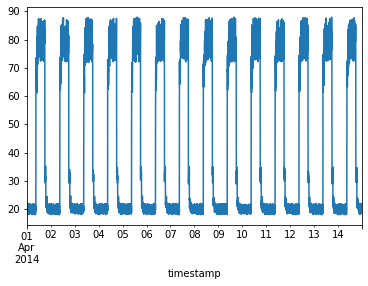

In [4]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

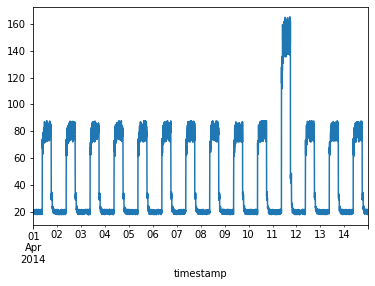

In [5]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

In [6]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [7]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


In [8]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

The code above creates a Sequential model using the keras library, which is a type of neural network that consists of a linear stack of layers.

The model has several layers of different types: Input, Conv1D, Dropout, Conv1DTranspose. Each layer performs a different operation on the input data and passes the result to the next layer in the stack.

The compile function is used to specify the optimization algorithm and loss function that will be used to train the model. The Adam optimizer and the mse (mean squared error) loss function are used in this case.

The summary function is called to print a summary of the model, including the number of parameters in each layer.

In [9]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 5s 128ms/step - loss: 0.5205 - val_loss: 0.1115
Epoch 2/50
27/27 [==============================] - 3s 107ms/step - loss: 0.0829 - val_loss: 0.0417
Epoch 3/50
27/27 [==============================] - 3s 101ms/step - loss: 0.0596 - val_loss: 0.0381
Epoch 4/50
27/27 [==============================] - 3s 100ms/step - loss: 0.0513 - val_loss: 0.0328
Epoch 5/50
27/27 [==============================] - 3s 123ms/step - loss: 0.0450 - val_loss: 0.0292
Epoch 6/50
27/27 [==============================] - 4s 146ms/step - loss: 0.0399 - val_loss: 0.0275
Epoch 7/50
27/27 [==============================] - 4s 137ms/step - loss: 0.0360 - val_loss: 0.0256
Epoch 8/50
27/27 [==============================] - 4s 133ms/step - loss: 0.0328 - val_loss: 0.0237
Epoch 9/50
27/27 [==============================] - 4s 134ms/step - loss: 0.0302 - val_loss: 0.0232
Epoch 10/50
27/27 [==============================] - 4s 134ms/step - loss: 0.0281 - val_loss: 0.0228

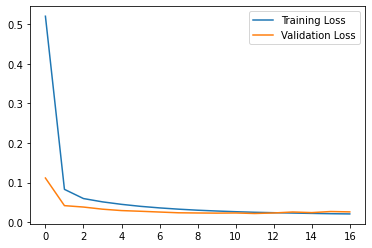

In [10]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

118/118 [==============================] - 2s 12ms/step


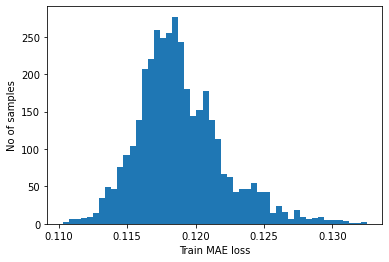

Reconstruction error threshold:  0.1325243649042421


In [11]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

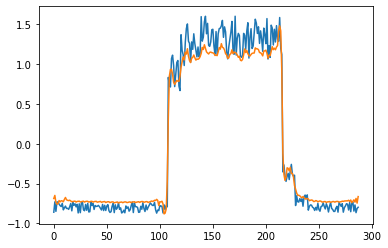

In [12]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

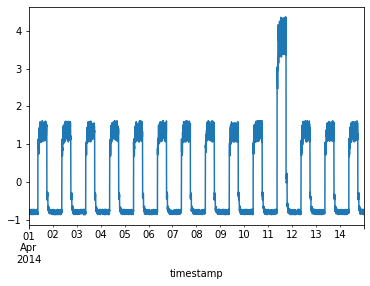

Test input shape:  (3745, 288, 1)
118/118 [==============================] - 1s 10ms/step


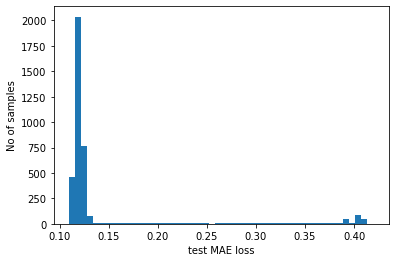

Number of anomaly samples:  410
Indices of anomaly samples:  (array([ 789,  795, 1651, 1652, 1653, 1654, 1658, 1659, 2517, 2521, 2522,
       2523, 2525, 2694, 2695, 2697, 2702, 2703, 2704, 2705, 2706, 2707,
       2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718,
       2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729,
       2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740,
       2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751,
       2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762,
       2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773,
       2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784,
       2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795,
       2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806,
       2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817,
       2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2

In [13]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [14]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

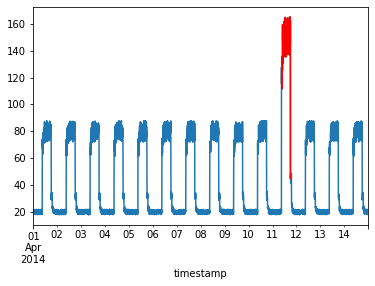

In [15]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()